In [1]:
#importing the required packages
import os
import matplotlib.pyplot as plt
import numpy as np
from keras import backend
import argparse
import random
import cv2
import glob

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
from keras import applications
from keras import Model

In [4]:
dataset_path = "Data\\gender_dataset_face_asian"
img_dims = (96,96,3)
data = []
labels = []

In [5]:
# load image files from the dataset
random.seed(42)
image_files = [f for f in glob.glob(dataset_path + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [6]:
# create groud-truth label from the image path
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label])

In [7]:
print(len(data))
print(len(labels))

10908
10908


In [8]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [9]:
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)


In [10]:
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [11]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=50, 
                         width_shift_range=0.3,
                         height_shift_range=0.4, 
                         shear_range=0.4, 
                         zoom_range=0.4,
                         horizontal_flip=True, 
                         fill_mode="nearest")

In [12]:
print("training x length: ", len(trainX))
print("testing x length: ", len(testY))

training x length:  8726
testing x length:  2182


In [13]:
# initial parameters
epochs = 100
lr_rate = 0.0001
batch_size = 64
drop_out = 0.20

## VGG 19

In [14]:
#Creating a function for saving the model at each epoch end
class LossHistory(Callback):
    def __init__(self):
        super().__init__()
        self.epoch_id = 0
        self.losses = ''
 
    def on_epoch_end(self, epoch, logs={}):
        self.losses += "Epoch {}: accuracy -> {:.3f}, val_accuracy -> {:.3f}\n"\
            .format(str(self.epoch_id), logs.get('acc'), logs.get('val_acc'))
        self.epoch_id += 1
 
    def on_train_begin(self, logs={}):
        self.losses += 'Training begins...\n'

In [15]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_dims[0], img_dims[1], 3))

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [17]:
len(model.layers)

22

In [18]:
# Freeze the layers which you don't want to train. 
for layer in model.layers[:17]:
    layer.trainable = False

In [19]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [20]:
# creating the final model 
model_final = Model(input = model.input, output = predictions)

C:\Users\NiranjanKumar\Anaconda3\envs\deepbackup\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [21]:
# compile the model 
model_final.compile(loss = "binary_crossentropy", optimizer = SGD(lr=lr_rate, momentum=0.9, decay=lr_rate/epochs), metrics=["accuracy"])

In [22]:
#summary of final model
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [23]:
print('Number of trainable weights before freezing the conv base:', len(model_final.trainable_weights))

Number of trainable weights before freezing the conv base: 16


In [24]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint(filepath = os.path.join('Detection\\Models', 'vgg19_3.h5'), monitor='val_acc', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [25]:
# Create a loss history 
#saving to text file
history = LossHistory()

In [26]:
# train the model
x = model_final.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, 
                        verbose=1, 
                        workers = 6, 
                        callbacks = [history, checkpoint], 
                        max_q_size = 100)

C:\Users\NiranjanKumar\Anaconda3\envs\deepbackup\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=136, epochs=100, validation_data=(array([[[..., verbose=1, callbacks=[<__main__..., max_queue_size=100, workers=6)`
  if __name__ == '__main__':


Epoch 1/100
136/136 [==============================] - 124s 915ms/step - loss: 0.6232 - acc: 0.6769 - val_loss: 0.4839 - val_acc: 0.7617

Epoch 00001: val_acc improved from -inf to 0.76169, saving model to Detection\Models\vgg19_3.h5
Epoch 2/100
136/136 [==============================] - 40s 294ms/step - loss: 0.5088 - acc: 0.7561 - val_loss: 0.3917 - val_acc: 0.8208

Epoch 00002: val_acc improved from 0.76169 to 0.82081, saving model to Detection\Models\vgg19_3.h5
Epoch 3/100
136/136 [==============================] - 40s 293ms/step - loss: 0.4732 - acc: 0.7782 - val_loss: 0.3761 - val_acc: 0.8346

Epoch 00003: val_acc improved from 0.82081 to 0.83456, saving model to Detection\Models\vgg19_3.h5
Epoch 4/100
136/136 [==============================] - 40s 293ms/step - loss: 0.4332 - acc: 0.8031 - val_loss: 0.3172 - val_acc: 0.8676

Epoch 00004: val_acc improved from 0.83456 to 0.86755, saving model to Detection\Models\vgg19_3.h5
Epoch 5/100
136/136 [==============================] - 40s

136/136 [==============================] - 40s 297ms/step - loss: 0.2097 - acc: 0.9169 - val_loss: 0.1170 - val_acc: 0.9601

Epoch 00040: val_acc improved from 0.95646 to 0.96013, saving model to Detection\Models\vgg19_3.h5
Epoch 41/100
136/136 [==============================] - 40s 296ms/step - loss: 0.2049 - acc: 0.9180 - val_loss: 0.1104 - val_acc: 0.9588

Epoch 00041: val_acc did not improve from 0.96013
Epoch 42/100
136/136 [==============================] - 40s 295ms/step - loss: 0.2102 - acc: 0.9128 - val_loss: 0.1026 - val_acc: 0.9647

Epoch 00042: val_acc improved from 0.96013 to 0.96471, saving model to Detection\Models\vgg19_3.h5
Epoch 43/100
136/136 [==============================] - 40s 297ms/step - loss: 0.2053 - acc: 0.9165 - val_loss: 0.1104 - val_acc: 0.9620

Epoch 00043: val_acc did not improve from 0.96471
Epoch 44/100
136/136 [==============================] - 40s 297ms/step - loss: 0.1995 - acc: 0.9187 - val_loss: 0.1456 - val_acc: 0.9409

Epoch 00044: val_acc did 


Epoch 00082: val_acc did not improve from 0.97067
Epoch 83/100
136/136 [==============================] - 40s 296ms/step - loss: 0.1542 - acc: 0.9398 - val_loss: 0.1057 - val_acc: 0.9629

Epoch 00083: val_acc did not improve from 0.97067
Epoch 84/100
136/136 [==============================] - 40s 295ms/step - loss: 0.1528 - acc: 0.9391 - val_loss: 0.1108 - val_acc: 0.9610

Epoch 00084: val_acc did not improve from 0.97067
Epoch 85/100
136/136 [==============================] - 40s 296ms/step - loss: 0.1547 - acc: 0.9396 - val_loss: 0.0908 - val_acc: 0.9675

Epoch 00085: val_acc did not improve from 0.97067
Epoch 86/100
136/136 [==============================] - 40s 296ms/step - loss: 0.1535 - acc: 0.9384 - val_loss: 0.0823 - val_acc: 0.9693

Epoch 00086: val_acc did not improve from 0.97067
Epoch 87/100
136/136 [==============================] - 40s 295ms/step - loss: 0.1662 - acc: 0.9336 - val_loss: 0.0856 - val_acc: 0.9684

Epoch 00087: val_acc did not improve from 0.97067
Epoch 88/

In [27]:
x.history.keys()

dict_keys(['acc', 'loss', 'val_loss', 'val_acc'])

In [28]:
plt.rcParams['figure.figsize'] = (12,20)
plt.style.use("seaborn")

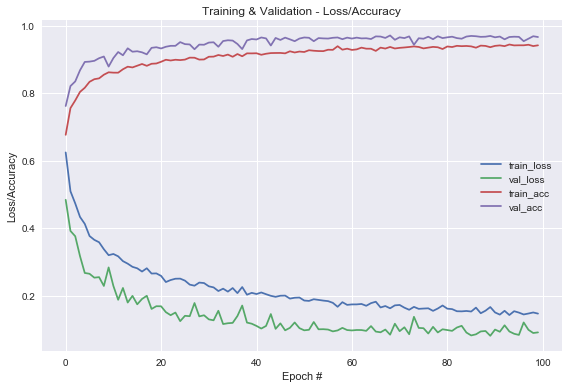

In [29]:
# plot training/validation loss/accuracy
N = epochs
plt.plot(np.arange(0,N), x.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), x.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), x.history["acc"], label="train_acc")
plt.plot(np.arange(0,N), x.history["val_acc"], label="val_acc")

plt.title("Training & Validation - Loss/Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.tight_layout()
plt.show()

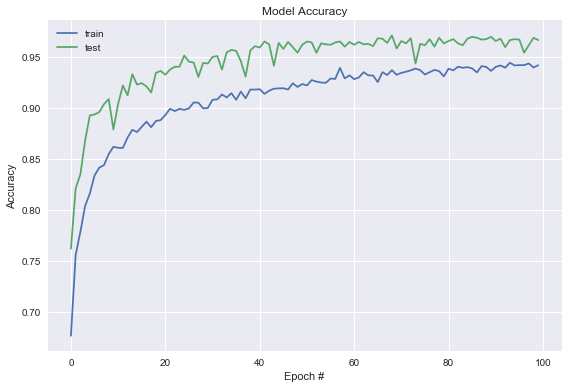

In [31]:
# summarize history for accuracy
plt.plot(x.history['acc'])
plt.plot(x.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

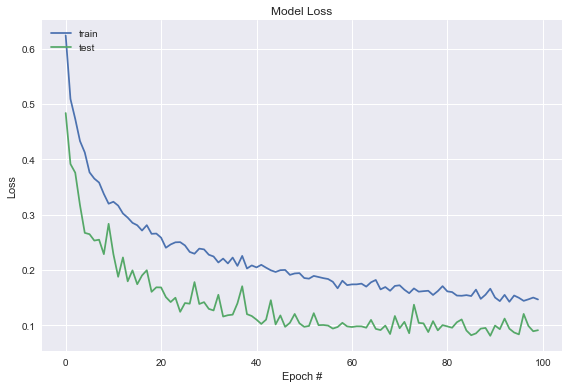

In [32]:
# summarize history for loss
plt.plot(x.history['loss'])
plt.plot(x.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [33]:
score = model_final.evaluate(testX, testY)
print("Accuracy on test data:", score[1])

2182/2182 [==============================] - 8s 4ms/step
Accuracy on test data: 0.966086159487


In [34]:
# Save loss history to file
loss_history_path = os.path.join('Detection\\Models', 'loss_history_transfer_vgg19_2.log')
myFile = open(loss_history_path, 'w+')
myFile.write(history.losses)
myFile.close()

In [35]:
backend.clear_session()